In [1]:
import pandas as pd
from pathlib import Path
path = Path("C:\\Users\\manch\\OneDrive\\Documents\\DEV\\MachineLearning\\datasets\\CTA_-_Ridership_-_Daily_Boarding_Totals_20241230.csv")

df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] #shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # no need for total, it's just bus+ rail
df = df.drop_duplicates() # remove duplicated months (2011-10and 2014-07)
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2024-10-27,U,312965,215594
2024-10-28,W,611041,389359
2024-10-29,W,652674,444706


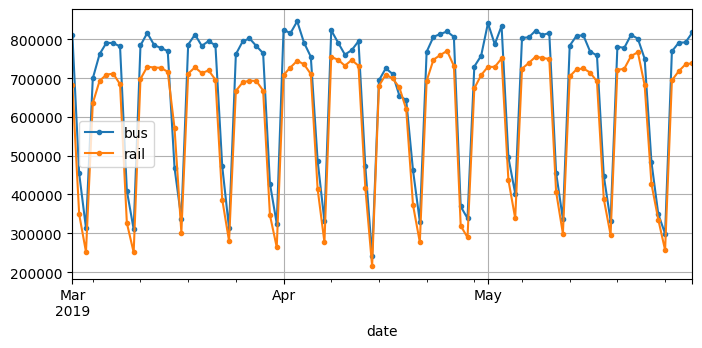

In [4]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.show()


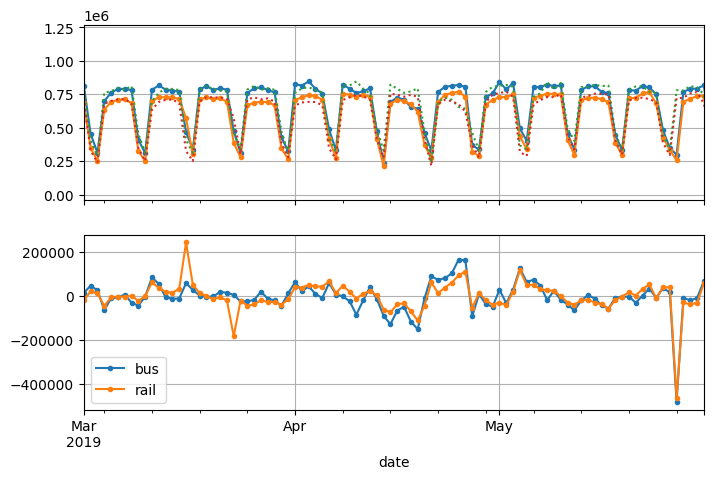

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original timeseries
df.shift(7).plot(ax=axs[0], grid=True, legend=False,linestyle=":") # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".") # 7-day differencetime series
plt.show()


In [6]:
diff_7.abs().mean()


bus     43915.608696
rail    42143.271739
dtype: float64

In [7]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()


bus     0.082938
rail    0.089948
dtype: float64

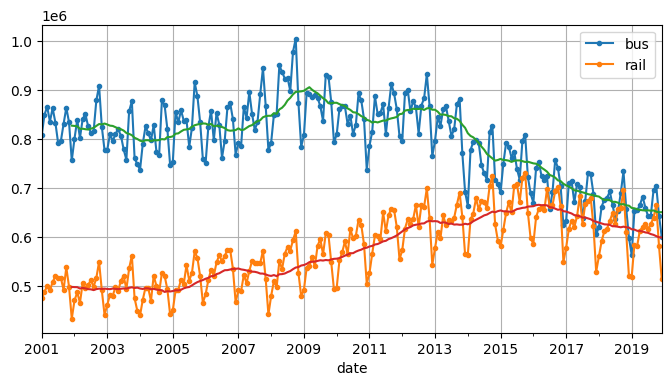

In [8]:
period = slice("2001", "2019")
df_monthly = df.resample('ME').mean(numeric_only=True) # compute the mean for eachmonth
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()


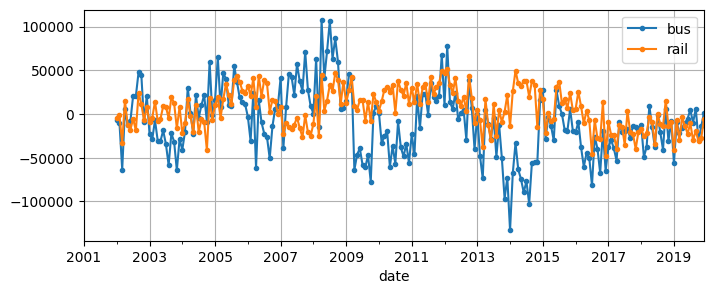

In [9]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()


In [143]:
from statsmodels.tsa.arima.model import ARIMA
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
 order=(1, 0, 0),
 seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast() # returns 427,758.6

In [144]:
y_pred

2019-06-01    427758.626222
Freq: D, dtype: float64

In [145]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], # train on data upto "today"
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7))
    model = model.fit() # note that we retrain the model everyday!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean() #returns 32,040.7

C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\manch\AppData\Local\Temp\ipykernel_16956\2134459007.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\User

KeyboardInterrupt: 

In [11]:
mae

32040.720090488467

Use keras to prepare data into sequences

In [14]:
import tensorflow as tf
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
 my_series,
 targets=my_series[3:], # the targets are 3 steps into thefuture
 sequence_length=3,
 batch_size=2
)


In [21]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [24]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()


0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [25]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [27]:
dataset = tf.data.Dataset.range(6).window(4, shift=1,
drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [28]:
def to_windows(dataset, length):
 dataset = dataset.window(length, shift=1,drop_remainder=True)
 return dataset.flat_map(lambda window_ds:window_ds.batch(length))


In [29]:
dataset = to_windows(tf.data.Dataset.range(6), 4) # 3 inputs+ 1 target = 4
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [2]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6


In [ ]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_train.to_numpy(),
                                                            targets=rail_train[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            seed=42
                                                        )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_valid.to_numpy(),
                                                            targets=rail_valid[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32
                                                        )

test_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            rail_test.to_numpy(),
                                                            targets=rail_test[seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32
                                                        )

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds,epochs=500,callbacks=[early_stopping_cb])


Epoch 1/500


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2528 - mae: 0.6094 - val_loss: 0.0120 - val_mae: 0.1212
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mae: 0.1573 - val_loss: 0.0068 - val_mae: 0.0929
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - mae: 0.1084 - val_loss: 0.0059 - val_mae: 0.0836
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - mae: 0.0963 - val_loss: 0.0047 - val_mae: 0.0725
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0804 - val_loss: 0.0054 - val_mae: 0.0759
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0821 - val_loss: 0.0043 - val_mae: 0.0685
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0755 - val_loss: 0.0041 - val_mae: 0.0669
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mae: 0.0709 - val_loss: 0.0040 - val_mae: 0.0660
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0

In [17]:
# Get MAE values for training and validation
mae_values = history.history['mae']  # training MAE
val_mae_values = history.history['val_mae']  # validation MAE

# Get loss values
loss_values = history.history['loss']  # training loss
val_loss_values = history.history['val_loss']  # validation loss

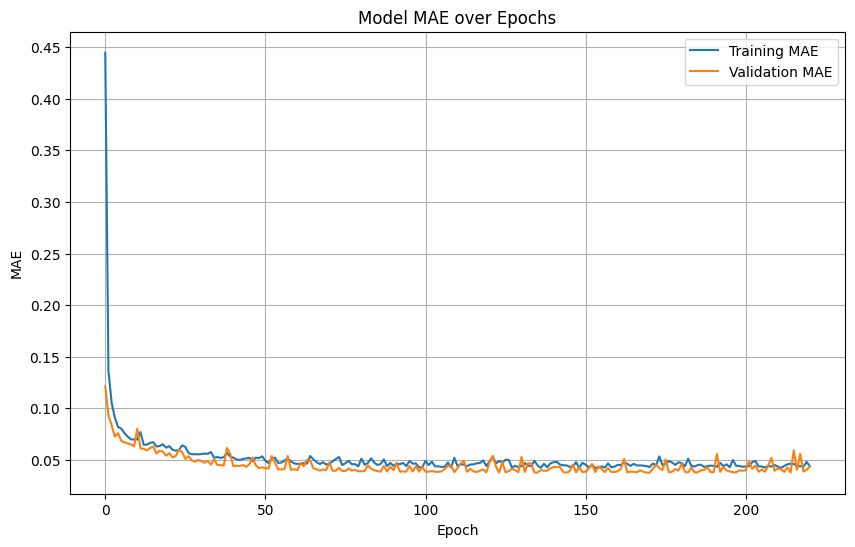

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Training MAE')
plt.plot(val_mae_values, label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Get predictions
test_predictions = model.predict(valid_ds)

# Since we're using a sequence length of 56, our predictions start at index 56
# We need to align the predictions with the actual values
actual_values = rail_valid[seq_length:].values
mae = (pd.DataFrame(test_predictions*1e6) - pd.DataFrame(actual_values*1e6)).abs().mean() 
mae

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


0    37568.678454
dtype: float64

A basic RNN one recurent layer one recurrent neuron

Input Shape of the RNN
The input to an RNN typically has the following dimensions:

Input Shape=(Batch Size,Sequence Length,Feature Dimension)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def ProcessTorchData(training_data,validation_data,seq_length,batch_size):
    # Reshape data for PyTorch
    train_data = training_data.to_numpy().reshape(-1, 1)
    valid_data = validation_data.to_numpy().reshape(-1, 1)

    X_train = torch.tensor(
                                [train_data[i:i + seq_length] for i in range(len(train_data) - seq_length)],
                                dtype=torch.float32
                            )
    y_train = torch.tensor(
                                train_data[seq_length:], dtype=torch.float32
                            )

    X_valid = torch.tensor(
                                [valid_data[i:i + seq_length] for i in range(len(valid_data) - seq_length)],
                                dtype=torch.float32
                            )
    y_valid = torch.tensor(
                                valid_data[seq_length:], dtype=torch.float32
                            )

    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    return train_loader,valid_loader

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, dropout=0.2):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Dropout applies only if `num_layers > 1`
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)  # Shape: (batch_size, seq_length, hidden_size)
        out = self.fc(rnn_output[:, -1, :])  # Only the last time step's output
        return out

class RNNTrainer:
    loss_functions = {
        "HuberLoss": nn.HuberLoss(delta=1),
        "MSELoss": nn.MSELoss(),
        "L1Loss": nn.L1Loss(),
    }
    
    optimizors = {
        "SGD": lambda model_params, lr: optim.SGD(model_params, lr=lr, momentum=0.9),
        "Adam": lambda model_params, lr: optim.Adam(model_params, lr=lr),
        "RMSprop": lambda model_params, lr: optim.RMSprop(model_params, lr=lr),
    }

    def __init__(self, model, train_loader, valid_loader, loss_f, optimizor, learning_rate=0.01, epochs=500):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        
        if loss_f not in self.loss_functions:
            raise ValueError(f"Invalid loss function '{loss_f}'. Available options are: {list(self.loss_functions.keys())}")
        
        if optimizor not in self.optimizors:
            raise ValueError(f"Invalid optimizer '{optimizor}'. Available options are: {list(self.optimizors.keys())}")

        self.criterion = self.loss_functions[loss_f]
        self.optimizer = self.optimizors[optimizor](self.model.parameters(), lr=learning_rate)

    @classmethod
    def available_options(cls):
        return {
            "loss_f": list(cls.loss_functions.keys()),
            "optimizors": list(cls.optimizors.keys()),
        }

    def fit(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in self.train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {train_loss:.4f}")

    def evaluate(self):
        self.model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in self.valid_loader:
                X_batch = X_batch.to(self.device)
                predictions.append(self.model(X_batch).cpu())
                actuals.append(y_batch)

        predictions = torch.cat(predictions).numpy()
        actuals = torch.cat(actuals).numpy()
        return predictions, actuals


In [ ]:
# Load and preprocess data
seq_length = 56
batch_size = 32

train_loader, valid_loader = ProcessTorchData(rail_train, rail_valid, seq_length, batch_size)

# Initialize the model and trainer
model = SimpleRNNModel(input_size=1, hidden_size=32, num_layers=1, dropout=0.2)
trainer = RNNTrainer(model, train_loader, valid_loader,loss_f="L1Loss",optimizor="SGD",learning_rate=0.01, epochs=500)

# Train the model
trainer.fit()

# Evaluate the model
predictions, actuals = trainer.evaluate()


C:\Users\manch\AppData\Local\Temp\ipykernel_15424\479743341.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train = torch.tensor(


Epoch 1/500, Loss: 0.2091
Epoch 2/500, Loss: 0.1381
Epoch 3/500, Loss: 0.1313
Epoch 4/500, Loss: 0.1276
Epoch 5/500, Loss: 0.1261
Epoch 6/500, Loss: 0.1268
Epoch 7/500, Loss: 0.1238
Epoch 8/500, Loss: 0.1225
Epoch 9/500, Loss: 0.1201
Epoch 10/500, Loss: 0.1199
Epoch 11/500, Loss: 0.1092
Epoch 12/500, Loss: 0.0985
Epoch 13/500, Loss: 0.0927
Epoch 14/500, Loss: 0.0866
Epoch 15/500, Loss: 0.0809
Epoch 16/500, Loss: 0.0754
Epoch 17/500, Loss: 0.0720
Epoch 18/500, Loss: 0.0720
Epoch 19/500, Loss: 0.0687
Epoch 20/500, Loss: 0.0687
Epoch 21/500, Loss: 0.0669
Epoch 22/500, Loss: 0.0642
Epoch 23/500, Loss: 0.0673
Epoch 24/500, Loss: 0.0643
Epoch 25/500, Loss: 0.0643
Epoch 26/500, Loss: 0.0680
Epoch 27/500, Loss: 0.0630
Epoch 28/500, Loss: 0.0632
Epoch 29/500, Loss: 0.0633
Epoch 30/500, Loss: 0.0607
Epoch 31/500, Loss: 0.0589
Epoch 32/500, Loss: 0.0623
Epoch 33/500, Loss: 0.0558
Epoch 34/500, Loss: 0.0526
Epoch 35/500, Loss: 0.0664
Epoch 36/500, Loss: 0.0591
Epoch 37/500, Loss: 0.0476
Epoch 38/5

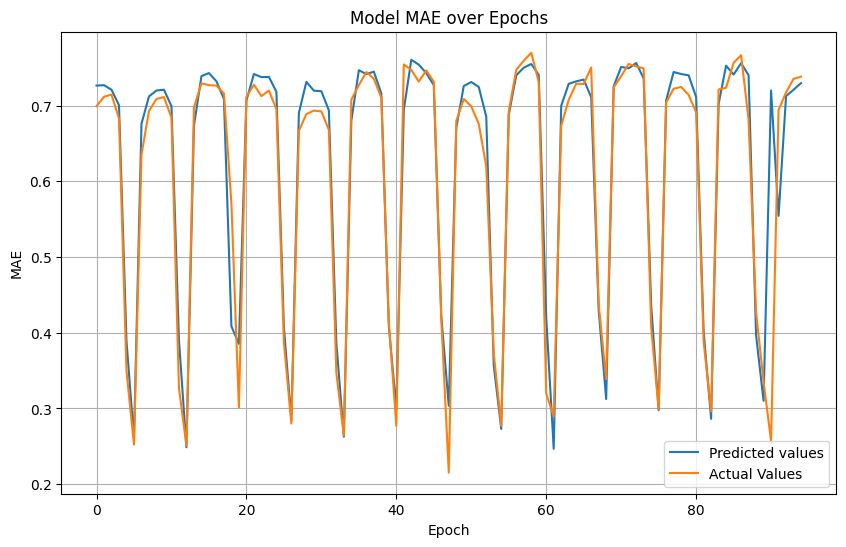

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted values')
plt.plot(actuals, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [6]:

# Rescale if necessary (e.g., multiplying by 1e6)
predictions = predictions * 1e6
actuals = actuals * 1e6

# Ensure they are 2D for DataFrame
predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = (predictions_df - actuals_df).abs().mean().values[0]
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 28219.423828125


In [31]:
#Custom cross validation algorithm to find the combination of loss and optimizer functions
loss_functions = [
                    "HuberLoss",
                    "MSELoss",
                    "L1Loss"
                ]

optimizors = [
                "SGD",
                "Adam",
                "RMSprop"
            ]

results     ={
                "option_1":{
                            "loss":"loss",
                            "opt":"opt",
                            "mae":"mae"
                            }
}

options=0
for loss_name in loss_functions:
    for opt_name in optimizors:
        # Load and preprocess data
        seq_length = 56
        batch_size = 32

        train_loader, valid_loader = ProcessTorchData(rail_train, rail_valid, seq_length, batch_size)

        # Initialize the model and trainer
        model = SimpleRNNModel(input_size=1, hidden_size=32, num_layers=1, dropout=0.2)
        trainer = RNNTrainer(model, train_loader, valid_loader,loss_f=loss_name,optimizor=opt_name,learning_rate=0.01, epochs=500)

        # Train the model
        trainer.fit()

        # Evaluate the model
        predictions, actuals = trainer.evaluate()
        # Rescale if necessary (e.g., multiplying by 1e6)
        predictions = predictions * 1e6
        actuals = actuals * 1e6

        # Ensure they are 2D for DataFrame
        predictions_df = pd.DataFrame(predictions.reshape(-1, 1))
        actuals_df = pd.DataFrame(actuals.reshape(-1, 1))

        # Calculate Mean Absolute Error (MAE)
        mae = (predictions_df - actuals_df).abs().mean().values[0]
        mini_result={
                    f"option_{options}":{
                                            "loss":loss_name,
                                            "opt":opt_name,
                                            "mae":mae
                                        }
                    }
        results.update(mini_result)
        options+=1

#36 minutes on gpu

Epoch 1/500, Loss: 0.0293
Epoch 2/500, Loss: 0.0153
Epoch 3/500, Loss: 0.0150
Epoch 4/500, Loss: 0.0147
Epoch 5/500, Loss: 0.0146
Epoch 6/500, Loss: 0.0143
Epoch 7/500, Loss: 0.0141
Epoch 8/500, Loss: 0.0137
Epoch 9/500, Loss: 0.0133
Epoch 10/500, Loss: 0.0131
Epoch 11/500, Loss: 0.0127
Epoch 12/500, Loss: 0.0125
Epoch 13/500, Loss: 0.0120
Epoch 14/500, Loss: 0.0116
Epoch 15/500, Loss: 0.0110
Epoch 16/500, Loss: 0.0104
Epoch 17/500, Loss: 0.0099
Epoch 18/500, Loss: 0.0093
Epoch 19/500, Loss: 0.0089
Epoch 20/500, Loss: 0.0087
Epoch 21/500, Loss: 0.0086
Epoch 22/500, Loss: 0.0085
Epoch 23/500, Loss: 0.0085
Epoch 24/500, Loss: 0.0082
Epoch 25/500, Loss: 0.0082
Epoch 26/500, Loss: 0.0080
Epoch 27/500, Loss: 0.0079
Epoch 28/500, Loss: 0.0079
Epoch 29/500, Loss: 0.0077
Epoch 30/500, Loss: 0.0076
Epoch 31/500, Loss: 0.0077
Epoch 32/500, Loss: 0.0076
Epoch 33/500, Loss: 0.0075
Epoch 34/500, Loss: 0.0074
Epoch 35/500, Loss: 0.0075
Epoch 36/500, Loss: 0.0073
Epoch 37/500, Loss: 0.0071
Epoch 38/5

In [32]:
# Convert the dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Optional: Reset the index for a clean numerical index
df_results.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df_results)



        loss      opt            mae
0  HuberLoss     Adam   82664.632812
1  HuberLoss      SGD   34666.652344
2  HuberLoss  RMSprop  188349.390625
3    MSELoss      SGD   33646.820312
4    MSELoss     Adam  110342.265625
5    MSELoss  RMSprop   74055.875000
6     L1Loss      SGD   29875.525391
7     L1Loss     Adam   79701.085938
8     L1Loss  RMSprop  148132.750000


In [33]:
# Sort by MAE in ascending order
df_results_sorted = df_results.sort_values(by="mae", ascending=True)
print(df_results_sorted)


        loss      opt            mae
6     L1Loss      SGD   29875.525391
3    MSELoss      SGD   33646.820312
1  HuberLoss      SGD   34666.652344
5    MSELoss  RMSprop   74055.875000
7     L1Loss     Adam   79701.085938
0  HuberLoss     Adam   82664.632812
4    MSELoss     Adam  110342.265625
8     L1Loss  RMSprop  148132.750000
2  HuberLoss  RMSprop  188349.390625


Forecasting Multivariate Time Series

This can be done by trying to forecast the rail time series using both
the bus and rail data as input. In fact, let’s also throw in the day type! Since
we can always know in advance whether tomorrow is going to be a
weekday, a weekend, or a holiday, we can shift the day type series one day
into the future, so that the model is given tomorrow’s day type as input.

In [12]:
import tensorflow as tf
import numpy as np

df_mulvar                   = df[["bus", "rail"]] / 1e6 # use both bus & rail series as input
df_mulvar["next_day_type"]  = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar                   = pd.get_dummies(df_mulvar) # one-hot encode the day type Now df_mulvar is a DataFrame with five columns: the bus and rail data,
                                                        # plus three columns containing the one-hot encoding of the next day’s type
                                                        # (recall that there are three possible day types, W, A, and U).

#Split the data into three periods. For training, validation, and testing:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test  = df_mulvar["2019-06":]

# Ensure all columns are numeric, converting booleans to float32
mulvar_train = mulvar_train.astype(np.float32)
mulvar_valid = mulvar_valid.astype(np.float32)
mulvar_test  = mulvar_test.astype(np.float32)

In [67]:
#Create the datasets:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                                mulvar_train.to_numpy(),                    # use all 5 columns as input
                                                                targets=mulvar_train["rail"].iloc[seq_length:].to_numpy(dtype=np.float32),  # forecast only the rail series
                                                                                                            # the other 4 arguments are the same as earlier
                                                                sequence_length=seq_length,
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                seed=42
                                                                )


valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                                mulvar_valid.to_numpy(),
                                                                targets=mulvar_valid["rail"].iloc[seq_length:].to_numpy(dtype=np.float32),
                                                                sequence_length=seq_length,
                                                                batch_size=batch_size

                                                                )


Epoch 1/500


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1131 - mae: 0.3627 - val_loss: 0.0047 - val_mae: 0.0823
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052 - mae: 0.0795 - val_loss: 0.0016 - val_mae: 0.0465
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - mae: 0.0410 - val_loss: 7.7103e-04 - val_mae: 0.0284
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - mae: 0.0471 - val_loss: 0.0011 - val_mae: 0.0386
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - mae: 0.0389 - val_loss: 0.0010 - val_mae: 0.0353
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0374 - val_loss: 8.4957e-04 - val_mae: 0.0310
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - mae: 0.0391 - val_loss: 0.0011 - val_mae: 0.0378
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - mae: 0.0365 - val_loss: 7.0995e-04 - val_mae: 0.0273
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - lo

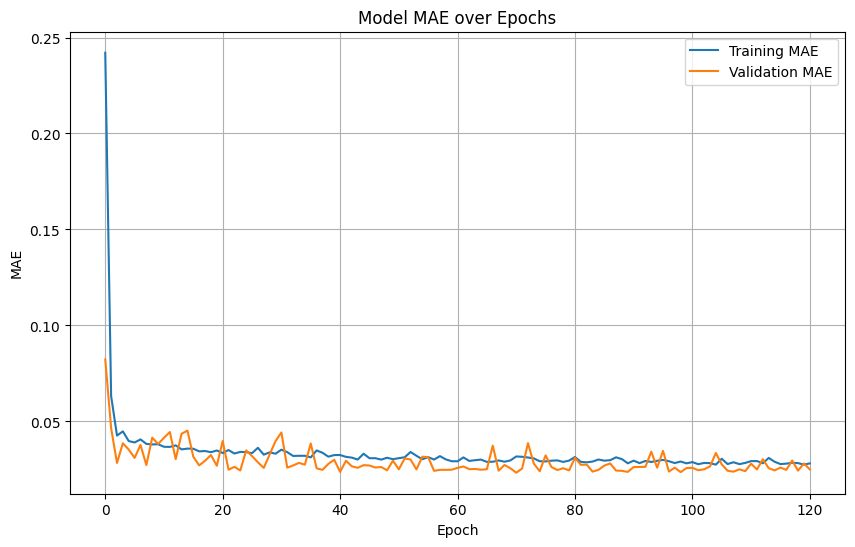

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
0    23303.5
dtype: float32


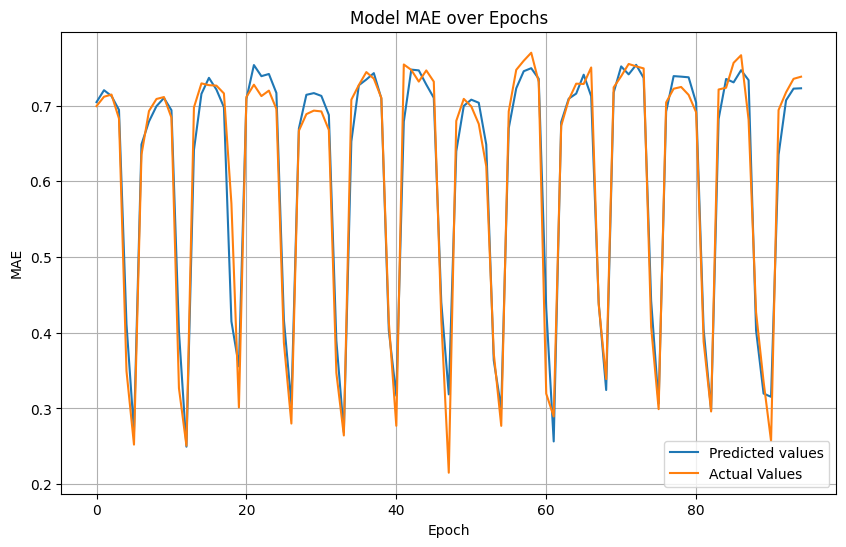

In [72]:
#Create the RNN:
mulvar_model = tf.keras.Sequential(
                                        [
                                            tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
                                            tf.keras.layers.Dense(1)
                                        ]
                                    )

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,metrics=["mae"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

history_mulvar_model    =   mulvar_model.fit(
                                                train_mulvar_ds, 
                                                validation_data=valid_mulvar_ds,
                                                epochs=500,
                                                callbacks=[early_stopping_cb]
        )
# Get MAE values for training and validation
mae_values = history_mulvar_model.history['mae']  # training MAE
val_mae_values = history_mulvar_model.history['val_mae']  # validation MAE

# Get loss values
loss_values = history_mulvar_model.history['loss']  # training loss
val_loss_values = history_mulvar_model.history['val_loss']  # validation loss

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Training MAE')
plt.plot(val_mae_values, label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions
test_predictions = mulvar_model.predict(valid_mulvar_ds)

# Since we're using a sequence length of 56, our predictions start at index 56
# We need to align the predictions with the actual values
actual_values = mulvar_valid["rail"][seq_length:].values
mae_1 = (pd.DataFrame(test_predictions*1e6) - pd.DataFrame(actual_values*1e6)).abs().mean() 
print(mae_1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predicted values')
plt.plot(actual_values, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/500


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0193 - mae: 0.1621 - val_loss: 0.0060 - val_mae: 0.0877
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0056 - mae: 0.0837 - val_loss: 0.0039 - val_mae: 0.0756
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035 - mae: 0.0645 - val_loss: 0.0031 - val_mae: 0.0666
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030 - mae: 0.0598 - val_loss: 0.0030 - val_mae: 0.0662
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - mae: 0.0596 - val_loss: 0.0027 - val_mae: 0.0623
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - mae: 0.0564 - val_loss: 0.0024 - val_mae: 0.0583
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025 - mae: 0.0539 - val_loss: 0.0018 - val_mae: 0.0481
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - mae: 0.0506 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0024 

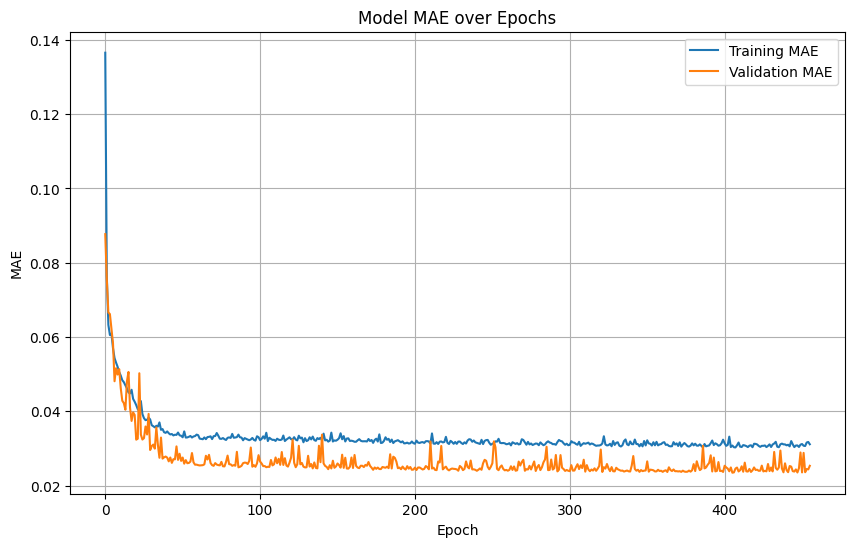

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/stepWARNING:tensorflow:5 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000210BC2113A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


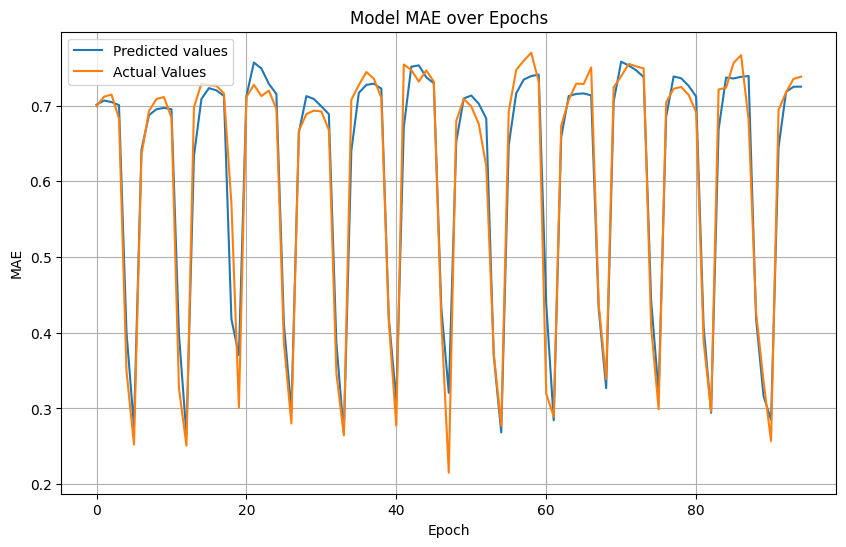

In [ ]:
#Create the GRU RNN:
mulvar_model = tf.keras.Sequential(
                                        [
                                            tf.keras.layers.GRU(32, input_shape=[None, 5]),
                                            tf.keras.layers.Dense(1)
                                        ]
                                    )

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,metrics=["mae"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

history_mulvar_model    =   mulvar_model.fit(
                                                train_mulvar_ds, 
                                                validation_data=valid_mulvar_ds,
                                                epochs=500,
                                                callbacks=[early_stopping_cb]
        )
# Get MAE values for training and validation
mae_values = history_mulvar_model.history['mae']  # training MAE
val_mae_values = history_mulvar_model.history['val_mae']  # validation MAE

# Get loss values
loss_values = history_mulvar_model.history['loss']  # training loss
val_loss_values = history_mulvar_model.history['val_loss']  # validation loss

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Training MAE')
plt.plot(val_mae_values, label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions
test_predictions = mulvar_model.predict(valid_mulvar_ds)

# Since we're using a sequence length of 56, our predictions start at index 56
# We need to align the predictions with the actual values
actual_values = mulvar_valid["rail"][seq_length:].values
mae = (pd.DataFrame(test_predictions*1e6) - pd.DataFrame(actual_values*1e6)).abs().mean() 
mae

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predicted values')
plt.plot(actual_values, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
mae

0    23480.816406
dtype: float32